In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from os.path import join
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [3]:
from utils_local import read_spreadsheet

In [4]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})

### Load the dataframe

In [5]:
df_linear = read_spreadsheet(gid_key="domain_shift_linear", index_col=0)
df_finetune = read_spreadsheet(gid_key="domain_shift_finetune", index_col=0)

In [6]:
# csv_path = "../../results/domain_shift_linear.csv"
# # csv_path = "../../results/domain_shift_finetune.csv"

In [7]:
# df = pd.read_csv(csv_path, index_col=0)

In [8]:
df_linear

,K400,UCF101,NTU60,SSv2,Gym99,EPIC (V)
None,0.00,0.00,0.00,0.00,0.00,0.00
SeLaVi,24.05,51.18,15.74,4.51,20.23,22.42
RSPNet,42.84,76.63,33.47,12.52,32.16,24.82
VideoMoCo,30.99,66.27,51.58,19.54,41.57,25.67
Pretext-contrast,22.35,57.15,17.61,10.86,29.98,20.04
CTP,7.61,37.93,22.58,12.20,30.62,20.04
TCLR,19.84,63.26,33.45,10.84,33.04,21.82
GDT,38.61,75.73,38.21,11.87,34.15,25.34
AVID-CMA,43.49,78.14,53.93,16.12,45.12,22.53
Supervised,0.00,91.65,45.49,16.58,42.74,26.59


In [9]:
df_finetune

,UCF101,NTU60,SSv2,Gym99,EPIC (V)
None,75.36,92.87,56.81,89.41,25.67
SeLaVi,84.88,92.78,56.37,88.93,33.77
RSPNet,88.47,93.90,59.39,91.28,42.67
VideoMoCo,85.83,94.09,58.75,90.54,43.61
Pretext-contrast,86.60,93.86,54.03,90.31,34.29
CTP,89.77,94.31,60.16,92.17,42.84
TCLR,90.77,94.11,59.64,91.49,36.18
GDT,91.14,93.89,57.78,90.36,37.26
AVID-CMA,89.33,93.99,53.82,90.56,29.91
Supervised,94.08,93.89,61.02,91.77,47.67


### Pre-processing

In [10]:
# remove column for `K400`
remove_K400 = True

if remove_K400:
    if "K400" in df_linear.columns:
        df_linear.drop(columns=["K400"], inplace=True)
    if "K400" in df_finetune.columns:
        df_finetune.drop(columns=["K400"], inplace=True)

In [11]:
# re-order datasets

def find_sub_element_in_list(x, L):
    """Finds an element in list L of which x is a substring"""
    for y in L:
        if x in y:
            return y

if remove_K400:
    correct_order = ["UCF", "NTU", "Gym", "SS", "EPIC"]
else:
    correct_order = ["K400", "UCF", "NTU", "Gym", "SS", "EPIC"]
reorder_colums = [find_sub_element_in_list(x, df_linear.columns) for x in correct_order]

df_linear = df_linear[reorder_colums]
df_finetune = df_finetune[reorder_colums]

In [12]:
df_linear

,UCF101,NTU60,Gym99,SSv2,EPIC (V)
None,0.00,0.00,0.00,0.00,0.00
SeLaVi,51.18,15.74,20.23,4.51,22.42
RSPNet,76.63,33.47,32.16,12.52,24.82
VideoMoCo,66.27,51.58,41.57,19.54,25.67
Pretext-contrast,57.15,17.61,29.98,10.86,20.04
CTP,37.93,22.58,30.62,12.20,20.04
TCLR,63.26,33.45,33.04,10.84,21.82
GDT,75.73,38.21,34.15,11.87,25.34
AVID-CMA,78.14,53.93,45.12,16.12,22.53
Supervised,91.65,45.49,42.74,16.58,26.59


In [13]:
df_finetune

,UCF101,NTU60,Gym99,SSv2,EPIC (V)
None,75.36,92.87,89.41,56.81,25.67
SeLaVi,84.88,92.78,88.93,56.37,33.77
RSPNet,88.47,93.90,91.28,59.39,42.67
VideoMoCo,85.83,94.09,90.54,58.75,43.61
Pretext-contrast,86.60,93.86,90.31,54.03,34.29
CTP,89.77,94.31,92.17,60.16,42.84
TCLR,90.77,94.11,91.49,59.64,36.18
GDT,91.14,93.89,90.36,57.78,37.26
AVID-CMA,89.33,93.99,90.56,53.82,29.91
Supervised,94.08,93.89,91.77,61.02,47.67


In [14]:
# re-order VSSL methods based on UCF performance

ref_dataset = find_sub_element_in_list("UCF", df_finetune.columns)
df_finetune.sort_values(ref_dataset, inplace=True)
df_linear = df_linear.loc[list(df_finetune.index)]

In [15]:
df_linear

,UCF101,NTU60,Gym99,SSv2,EPIC (V)
None,0.00,0.00,0.00,0.00,0.00
MoCo,65.40,29.53,29.66,9.68,0.00
SeLaVi,51.18,15.74,20.23,4.51,22.42
VideoMoCo,66.27,51.58,41.57,19.54,25.67
Pretext-contrast,57.15,17.61,29.98,10.86,20.04
RSPNet,76.63,33.47,32.16,12.52,24.82
AVID-CMA,78.14,53.93,45.12,16.12,22.53
CTP,37.93,22.58,30.62,12.20,20.04
TCLR,63.26,33.45,33.04,10.84,21.82
GDT,75.73,38.21,34.15,11.87,25.34


In [16]:
df_finetune

,UCF101,NTU60,Gym99,SSv2,EPIC (V)
None,75.36,92.87,89.41,56.81,25.67
MoCo,83.80,93.41,83.62,52.42,0.00
SeLaVi,84.88,92.78,88.93,56.37,33.77
VideoMoCo,85.83,94.09,90.54,58.75,43.61
Pretext-contrast,86.60,93.86,90.31,54.03,34.29
RSPNet,88.47,93.90,91.28,59.39,42.67
AVID-CMA,89.33,93.99,90.56,53.82,29.91
CTP,89.77,94.31,92.17,60.16,42.84
TCLR,90.77,94.11,91.49,59.64,36.18
GDT,91.14,93.89,90.36,57.78,37.26


### Column-wise normalized

In [18]:
def heatmap(
        df,
        figsize=(7, 6),
        title="Action classification",
        titlesize=20,
        labelsize=15,
        tickssize=13,
        save=False,
        save_path="../../results/plots/sample.pdf",
        **kwargs,
    ):
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    if "cmap" not in kwargs:
        kwargs.update(dict(cmap="YlGnBu"))
    sns.heatmap(df, ax=ax, **kwargs)

    ax.set_title(title, fontsize=titlesize)

    ax.set_xlabel("Dataset")
    ax.set_ylabel("Method")
    
    ax.yaxis.label.set_size(labelsize)
    ax.xaxis.label.set_size(labelsize)

    ax.tick_params(axis='x', labelsize=tickssize)
    ax.tick_params(axis='y', labelsize=tickssize)
    
    if save:
        plt.savefig(save_path, bbox_inches="tight")

    plt.show()

### Normalizing between 0-1

In [19]:
normalized_df_linear=(df_linear-df_linear.min())/(df_linear.max()-df_linear.min())
normalized_df_finetune=(df_finetune-df_finetune.min())/(df_finetune.max()-df_finetune.min())

In [41]:

# annot = (df - df.T["None"]).values

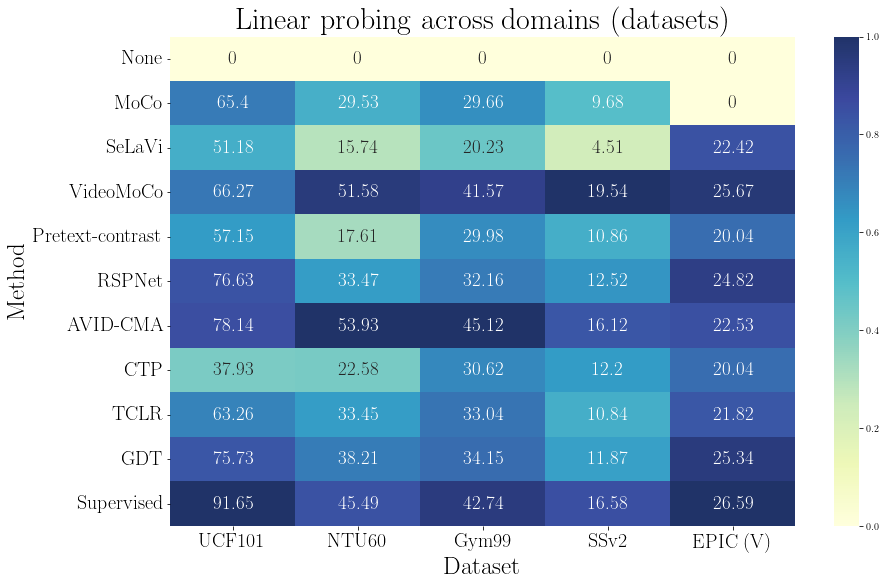

In [21]:
heatmap(
    normalized_df_linear,
    figsize=(14, 9),
    title="Linear probing across domains (datasets)",
    titlesize=30,
    labelsize=25,
    tickssize=20,
    save=True,
    save_path="../../results/plots/domain_shift_linear_v2.pdf",
    cmap="YlGnBu",
    alpha=0.9,
    annot=df_linear.values,
    fmt='g',
    annot_kws={"size": 19},
)

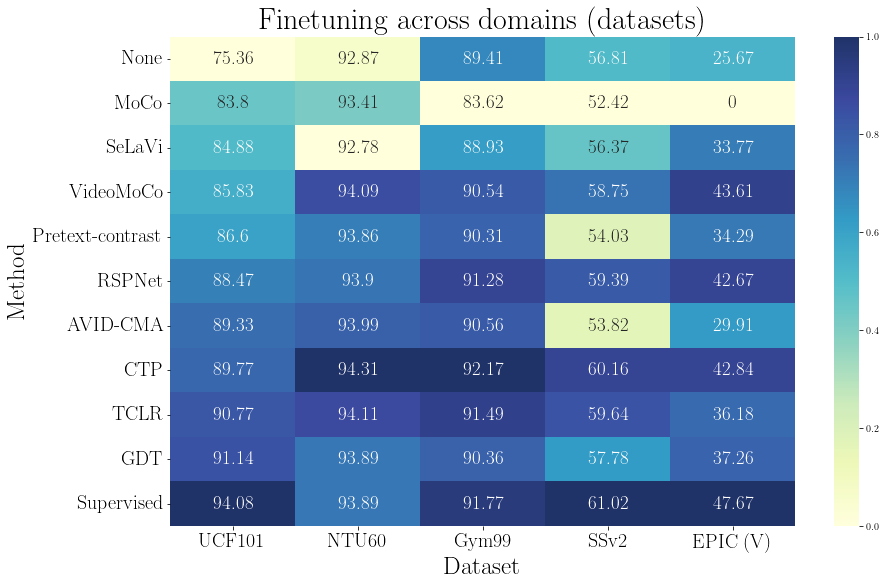

In [22]:
heatmap(
    normalized_df_finetune,
    figsize=(14, 9),
    title="Finetuning across domains (datasets)",
    titlesize=30,
    labelsize=25,
    tickssize=20,
    save=True,
    save_path="../../results/plots/domain_shift_finetune_v2.pdf",
    cmap="YlGnBu",
    alpha=0.9,
    annot=df_finetune.values,
    fmt='g',
    annot_kws={"size": 19},
)

### Relative improvement w.r.t. scratch

In [42]:
# normalized_df = (df - df.loc["None"]) / (df.loc["None"])
normalized_df = (df - df.loc["None"])
normalized_df /= normalized_df.max()

In [43]:
normalized_df

,UCF101,NTU,Something-something,FineGym,EPIC (Verb)
None,0.000000,0.000000,0.000000,0.000000,0.000000
SeLaVi,0.508547,-0.062500,-0.104513,-0.173913,0.368182
RSPNet,0.546474,0.444444,-0.726841,0.170290,0.479545
VideoMoCo,0.559295,0.847222,0.460808,0.409420,0.815455
Pretext-contrast,0.600427,0.687500,-0.660333,0.326087,0.391818
CTP,0.769765,1.000000,0.795724,1.000000,0.780455
TCLR,0.823184,0.861111,0.672209,0.753623,0.477727
GDT,0.842949,0.708333,0.230404,0.344203,0.526818
Supervised,1.000000,0.708333,1.000000,0.855072,1.000000


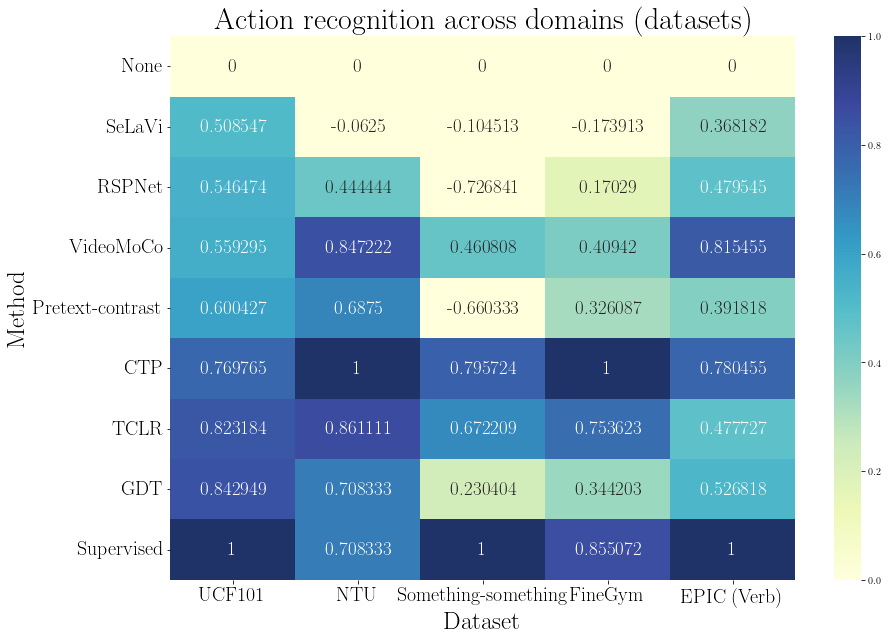

In [44]:
heatmap(
    normalized_df,
    figsize=(14, 10),
    title="Action recognition across domains (datasets)",
    titlesize=30,
    labelsize=25,
    tickssize=20,
    save=True,
    save_path="../../results/plots/domains_expt_2.pdf",
    cmap="YlGnBu",
    alpha=0.9,
    annot=normalized_df.values,
    fmt='g',
    vmin=0.0,
    vmax=1.0,
    annot_kws={"size": 19},
)

### Rank correlation

In [14]:
keys = df.columns

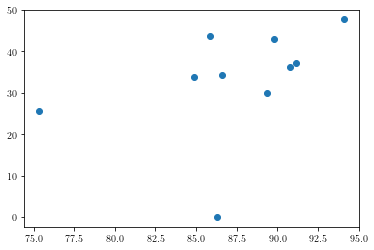

In [15]:
plt.scatter(df["UCF101"].values, df["EPIC (V)"].values)

[]

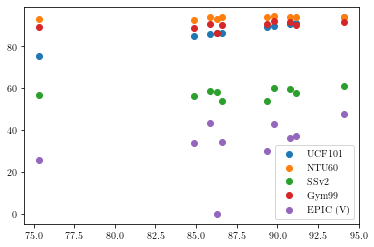

In [16]:
for key in keys:
    plt.scatter(df["UCF101"].values, df[key].values, label=key)
    
plt.legend()
plt.plot()